# 1. Configuración Inicial

In [6]:
# Instalación de paquetes necesarios
!pip install optuna torchvision folium --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 23.3 MB/s eta 0:00:00


## 1.1 Importación de librerías y versiones
- Librerías
- Comprobación de versiones

In [7]:
# Librerías
import os
import pandas as pd
from google.colab import drive
import cv2
import folium
import folium.plugins as plugins
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils
import torchvision.models as models
from PIL import Image
import ast
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorboard import program
from torchvision import transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split

In [8]:
# Comprobación de versiones
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Optuna version: {optuna.__version__}")

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
NumPy version: 2.0.2
Pandas version: 2.2.2
Optuna version: 4.4.0


## 1.2 Fijado de semilla y reproducibilidad
- Semilla

In [9]:
# Semilla
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)


## 1.3 Montaje de Google Drive y carga de datos
- Montar Google Drive
- Definir la ruta base a la carpeta del proyecto
- Construir la ruta al archivo de datos usando os.path.join
- Cargar los datos

In [11]:
# Montar Google Drive
drive.mount('/content/drive')

# Definir la ruta base a la carpeta del proyecto
BASE_PATH = '/content/drive/MyDrive/ProyectoDL'

# Construir la ruta al archivo de datos usando os.path.join
data_path = os.path.join(BASE_PATH, 'data', 'poi_dataset.csv')

# Cargar los datos
try:
    df = pd.read_csv(data_path)
    print("¡Archivo cargado exitosamente!")
    print(f"Ruta del archivo: {data_path}")
    print(df.head())

except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo en la ruta '{data_path}'")
    print("Por favor, verifica que la ruta y el nombre del archivo son correctos.")



Mounted at /content/drive
¡Archivo cargado exitosamente!
Ruta del archivo: /content/drive/MyDrive/ProyectoDL/data/poi_dataset.csv
                                     id  \
0  4b36a3ed-3b28-4bc7-b975-1d48b586db03   
1  e32b3603-a94f-49df-8b31-92445a86377c   
2  0123a69b-13ac-4b65-a5d5-71a95560cff5   
3  390d7d9e-e972-451c-b5e4-f494af15e788   
4  023fc1bf-a1cd-4b9f-af78-48792ab1a294   

                                                name  \
0                                  Galería Fran Reus   
1                            Convento de San Plácido   
2             Instituto Geológico y Minero de España   
3                              Margarita Gil Roësset   
4  Museo del Traje. Centro de Investigación del P...   

                                    shortDescription  \
0  La Galería Fran Reus es un espacio dedicado a ...   
1  El Convento de San Plácido en Madrid, fundado ...   
2  El Instituto Geológico y Minero de España, sit...   
3  Margarita Gil Roësset, escultora y poetisa esp.

# 2. Análisis Exploratorio de Datos (EDA)


## 2.1 Descripción general del dataset

- Primeras filas de los datos
- Información general y tipos de datos
- Dimensiones del dataset


In [12]:
# Primeras filas de los datos
df.head()

id  \
0  4b36a3ed-3b28-4bc7-b975-1d48b586db03   
1  e32b3603-a94f-49df-8b31-92445a86377c   
2  0123a69b-13ac-4b65-a5d5-71a95560cff5   
3  390d7d9e-e972-451c-b5e4-f494af15e788   
4  023fc1bf-a1cd-4b9f-af78-48792ab1a294   

                                                name  \
0                                  Galería Fran Reus   
1                            Convento de San Plácido   
2             Instituto Geológico y Minero de España   
3                              Margarita Gil Roësset   
4  Museo del Traje. Centro de Investigación del P...   

                                    shortDescription  \
0  La Galería Fran Reus es un espacio dedicado a ...   
1  El Convento de San Plácido en Madrid, fundado ...   
2  El Instituto Geológico y Minero de España, sit...   
3  Margarita Gil Roësset, escultora y poetisa esp...   
4  El Museo del Traje de Madrid, fundado en 2004,...   

                   categories  tier  locationLon  locationLat tags  xps  \
0    ['Escultura', 'Pintura']     1     2.642262    39.572694   []  500   
1  ['Patrimonio', 'Historia']     1    -3.704467    40.423037   []  500   
2   ['Ciencia', 'Patrimonio']     2    -3.699694    40.442045   []  250   
3                 ['Cultura']     1    -3.691228    40.427256   []  500   
4   ['Patrimonio', 'Cultura']     1    -3.727822    40.439665   []  500   

   Visits  Likes  Dislikes  Bookmarks  \
0   10009    422      3582         78   
1   10010   7743        96       2786   
2   10015   3154       874        595   
3   10011   8559        79       2358   
4   10020    915      2896        143   

                                     main_image_path  
0  data_main/4b36a3ed-3b28-4bc7-b975-1d48b586db03...  
1  data_main/e32b3603-a94f-49df-8b31-92445a86377c...  
2  data_main/0123a69b-13ac-4b65-a5d5-71a95560cff5...  
3  data_main/390d7d9e-e972-451c-b5e4-f494af15e788...  
4  data_main/023fc1bf-a1cd-4b9f-af78-48792ab1a294...

In [13]:
# Información general del dataset
print("\nInformación del dataset:")
df.info()


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1569 non-null   object 
 1   name              1569 non-null   object 
 2   shortDescription  1569 non-null   object 
 3   categories        1569 non-null   object 
 4   tier              1569 non-null   int64  
 5   locationLon       1569 non-null   float64
 6   locationLat       1569 non-null   float64
 7   tags              1569 non-null   object 
 8   xps               1569 non-null   int64  
 9   Visits            1569 non-null   int64  
 10  Likes             1569 non-null   int64  
 11  Dislikes          1569 non-null   int64  
 12  Bookmarks         1569 non-null   int64  
 13  main_image_path   1569 non-null   object 
dtypes: float64(2), int64(6), object(6)
memory usage: 171.7+ KB


In [14]:
# Dimensiones (filas, columnas)
print("\nDimensión Dataset:")
df.shape


Dimensión Dataset:


(1569, 14)

## 2.2 Valores nulos

- Conteo de valores nulos por columna

In [15]:
# Conteo de valores nulos por columna
print("\nValores nulos por columna:")
print(df.isnull().sum())


Valores nulos por columna:
id                  0
name                0
shortDescription    0
categories          0
tier                0
locationLon         0
locationLat         0
tags                0
xps                 0
Visits              0
Likes               0
Dislikes            0
Bookmarks           0
main_image_path     0
dtype: int64


## 2.3 Análisis de variables numéricas

- Estadística Descriptiva de las variables numéricas:
  - Visits
  - Likes
  - Dislikes
  - Bookmarks
  - tier
  - xps
- Histograma



In [16]:
# Estadísticas descriptivas
df[["Visits", "Likes", "Dislikes", "Bookmarks", "tier", "xps"]].describe().round()

Visits    Likes  Dislikes  Bookmarks    tier     xps
count   1569.0   1569.0    1569.0     1569.0  1569.0  1569.0
mean   10012.0   3624.0    2526.0      973.0     2.0   750.0
std        5.0   4818.0    2226.0     1453.0     1.0   228.0
min    10001.0    100.0      52.0       50.0     1.0     0.0
25%    10008.0    464.0     937.0      116.0     1.0   600.0
50%    10011.0   1434.0    2718.0      306.0     1.0   700.0
75%    10015.0   6840.0    3399.0     1309.0     2.0  1000.0
max    10038.0  26425.0   10999.0     8157.0     4.0  1000.0

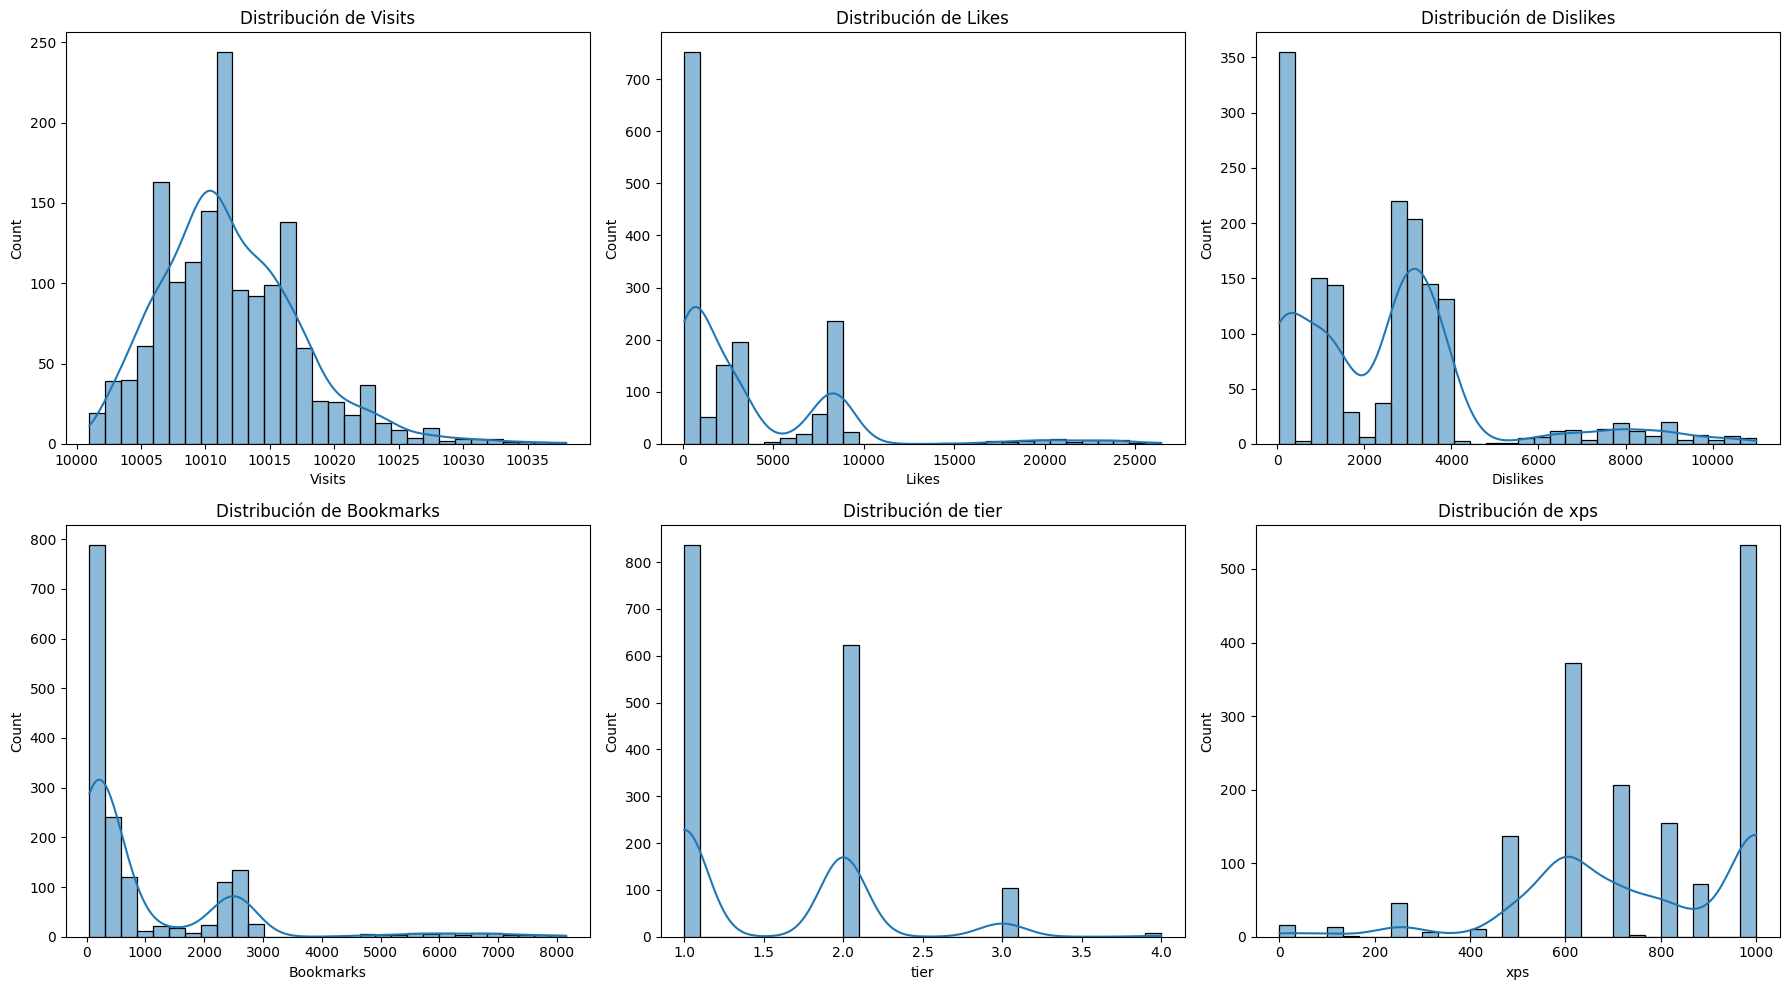

In [17]:
# Histograma
numeric_vars = ["Visits", "Likes", "Dislikes", "Bookmarks", "tier", "xps"]

plt.figure(figsize=(18, 10))
for i, var in enumerate(numeric_vars):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[var], bins=30, kde=True)
    plt.title(f'Distribución de {var}')
plt.tight_layout()
plt.show()

- **Visits** tiene una media y mediana muy próximas, pero un rango muy estrecho (min=10001, max=10038), lo que indica poca variabilidad en el número de visitas entre los POIs.
- **Likes**, **Dislikes** y **Bookmarks** presentan rangos mucho más amplios y distribuciones asimétricas (la media es mucho mayor que la mediana), lo que indica posible presencia de outliers o asimetría positiva.
- **tier** varía entre 1 y 4, siendo 1 el valor más frecuente (mediana=1).
- **xps** varía entre 0 y 1000, con percentiles altos bastante agrupados en torno al máximo.

**Conclusión:**  
Las variables `Likes`, `Dislikes` y `Bookmarks` pueden necesitar un tratamiento especial de outliers o al menos una exploración visual para entender su dispersión.  
La variable `Visits` tiene muy poca variabilidad, por lo que puede aportar poco poder predictivo.

## 2.4 Análisis de variables categóricas

- Análisis de las variables categóricas:

  - tier
    - Valores únicos encontrados.
    - Frecuencia.

  - categories
    - Número total de categorías únicas detectadas.
    - Top 10 categorías más frecuentes.

  - tags
    - Número total de tags únicos.
    - Top 10 tags más frecuentes.

- Visualización de las frecuencias


In [18]:
# Análisis de la variable 'tier'
print("Valores únicos en 'tier':", df["tier"].unique())
print("Frecuencia de 'tier':")
print(df["tier"].value_counts())
print("\n")

Valores únicos en 'tier': [1 2 3 4]
Frecuencia de 'tier':
tier
1    837
2    622
3    103
4      7
Name: count, dtype: int64




In [19]:
# Variable 'categories'
all_categories = [cat for cats in df["categories"].apply(eval) for cat in cats]
unique_categories = set(all_categories)
cat_frequencies = pd.Series(all_categories).value_counts()
print("Valores únicos de 'categories':")
print(df["categories"].unique()[:5])
print("Número total de categorías únicas:", len(cat_frequencies))
print("Top 10 categorías más frecuentes:")
print(cat_frequencies.head(10))
print("\n")

Valores únicos de 'categories':
["['Escultura', 'Pintura']" "['Patrimonio', 'Historia']"
 "['Ciencia', 'Patrimonio']" "['Cultura']" "['Patrimonio', 'Cultura']"]
Número total de categorías únicas: 12
Top 10 categorías más frecuentes:
Historia        1297
Cultura         1030
Arquitectura     660
Patrimonio       603
Escultura        482
Misterio         382
Ciencia          132
Ocio              76
Pintura           48
Naturaleza        43
Name: count, dtype: int64




In [20]:
# Análisis de la variable 'tags'
all_tags = [tag for tags in df["tags"].apply(eval) for tag in tags]
tag_frequencies = pd.Series(all_tags).value_counts()

print("\nValores únicos de 'tags' en la muestra:")
print(df["tags"].unique()[:5])
print("Número total de tags únicos:", len(tag_frequencies))
print("Top 10 tags más frecuentes:")
print(tag_frequencies.head(10))


Valores únicos de 'tags' en la muestra:
['[]' "['s.XX']"
 "['Canaletto', 'paisaje', 'vedutismo', 's.XVIII', 'Cuadro', 'Venecia']"
 "['s.XX', 'Primera Guerra Mundial ', 'expresionismo', 'paisaje', 'Cuadro']"
 "['Cuadro', 's.XX']"]
Número total de tags únicos: 2935
Top 10 tags más frecuentes:
Historia        802
Madrid          700
Cultura         583
Arquitectura    398
Patrimonio      353
Arte            329
Escultura       328
Estatua         269
Monumento       166
Naturaleza      150
Name: count, dtype: int64


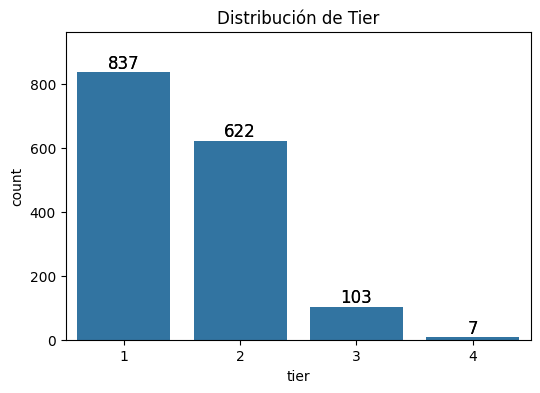

In [21]:
# Countplot para 'tier'
plt.figure(figsize=(6,4))
ax = sns.countplot(x="tier", data=df, color="#3c8dbc")
sns.countplot(x="tier", data=df)
plt.title("Distribución de Tier")

# Añade el valor sobre cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

plt.ylim(0, df['tier'].value_counts().max()*1.15)
plt.show()

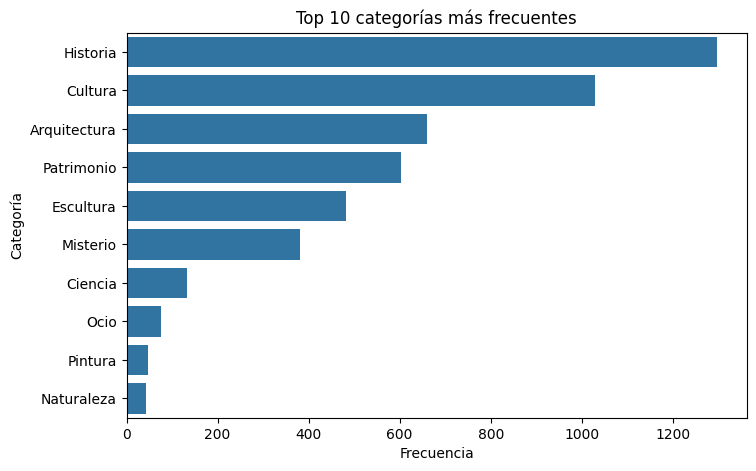

In [22]:
# Barplot para top 10 categorías
all_cats = [cat for cats in df['categories'].apply(eval) for cat in cats]
cat_freq = pd.Series(all_cats).value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(y=cat_freq.index, x=cat_freq.values)
plt.title("Top 10 categorías más frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("Categoría")
plt.show()

## 2.5 Visualización geoespacial de los POIs

- Mapa interactivo con la ubicación de todos los POIs y popup informativo.

In [23]:
# Mapa centrado en la media de las coordenadas
center_lat = df['locationLat'].mean()
center_lon = df['locationLon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Añadir marcadores para cada POI
for idx, row in df.iterrows():
    # Creación de el popup con información relevante
    popup_text = f"""
    <b>{row['name']}</b><br>
    Tier: {row['tier']}<br>
    Categories: {', '.join(eval(row['categories']))}<br>
    Visits: {row['Visits']}<br>
    Likes: {row['Likes']}<br>
    """
    # Marcador
    folium.Marker(
        location=[row['locationLat'], row['locationLon']],
        popup=popup_text,
        icon=folium.Icon(color='red' if row['tier'] == 1 else 'blue')
    ).add_to(m)

# Control de capas y minimapa
folium.LayerControl().add_to(m)
plugins.MiniMap().add_to(m)

#Mostrar mapa
m

## 2.6 Visualización exploratoria de imágenes

- Grid de imágenes aleatorias de POIs con su nivel de tier.


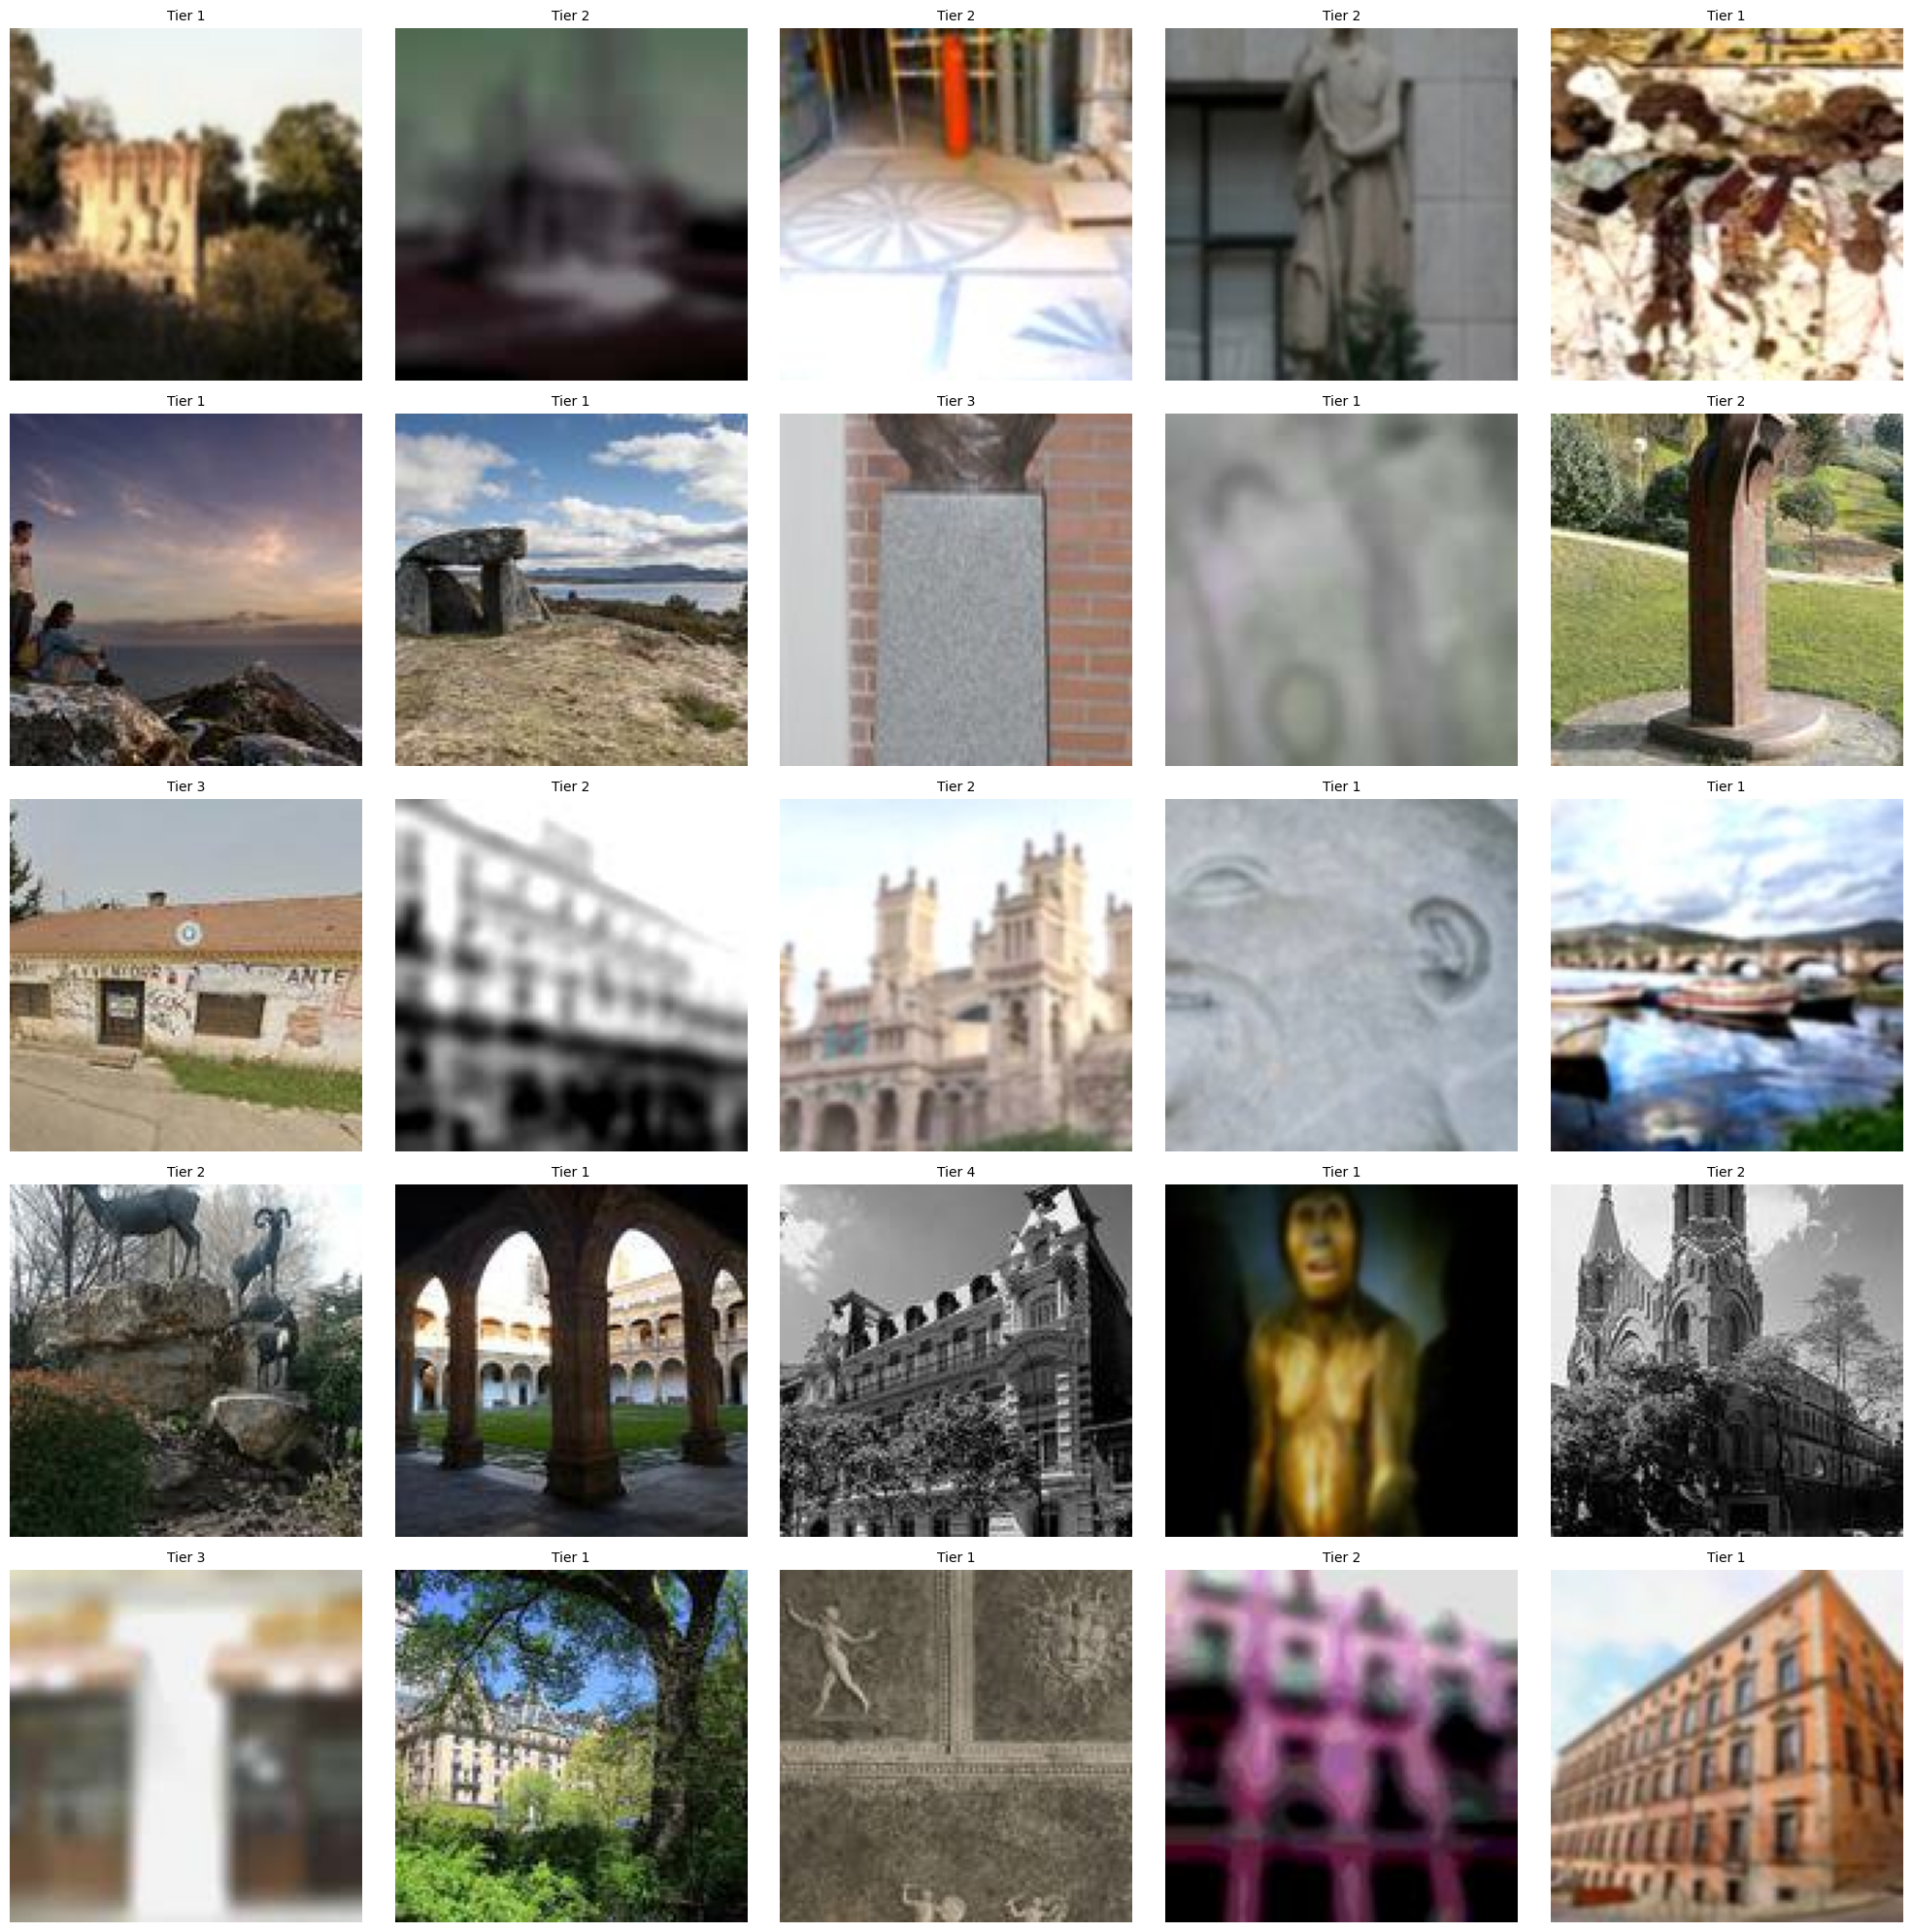

In [24]:
# Selecciona 25 imágenes aleatorias
sample_images = df.sample(n=25, random_state=42)

plt.figure(figsize=(20, 20))
for idx, (_, row) in enumerate(sample_images.iterrows()):
    # Construye la ruta completa a la imagen
    img_path = os.path.join(BASE_PATH,'data', row['main_image_path'])
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        # Si la imagen no existe, muestra un cuadro blanco
        img = np.ones((224, 224, 3), dtype=np.uint8) * 255
    plt.subplot(5, 5, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Tier {row['tier']}", fontsize=10)
plt.tight_layout()
plt.show()


## 2.7 Creación y normalización de la métrica de engagement

- Normalización automática de Visits, Likes, Bookmarks y Dislikes.
- Cálculo de la métrica ponderada de engagement.

**bold text**


In [25]:
# Selección de columnas a normalizar
features = ['Likes', 'Bookmarks', 'Dislikes']
scaler = MinMaxScaler()

# Normalización automática
df[[f'{col}_norm' for col in features]] = scaler.fit_transform(df[features])

# Cálculo de la métrica Engagement
df['engagement_score'] = (
    df['Likes_norm'] * 0.6 +
    df['Bookmarks_norm'] * 0.4 -
    df['Dislikes_norm'] * 0.2
)

## 2.8 Visualización y análisis del engagement score

- Histograma.
- Boxplot.
- Estadísticas descriptivas básicas.

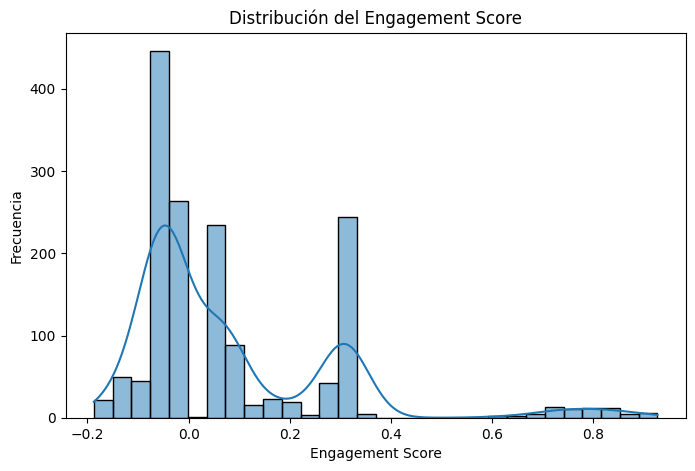

In [26]:
# Histograma de la métrica de engagement
plt.figure(figsize=(8, 5))
sns.histplot(df['engagement_score'], bins=30, kde=True)
plt.title('Distribución del Engagement Score')
plt.xlabel('Engagement Score')
plt.ylabel('Frecuencia')
plt.show()

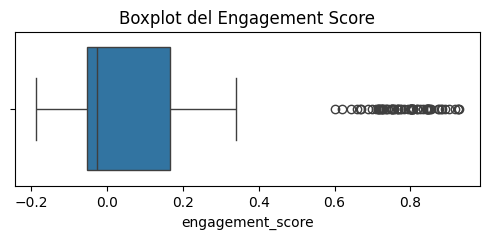

In [27]:
# Boxplot del engagement score
plt.figure(figsize=(6, 2))
sns.boxplot(x=df['engagement_score'])
plt.title('Boxplot del Engagement Score')
plt.show()

In [28]:
# Estadísticas descriptivas
print("Estadísticas del engagement score:")
df['engagement_score'].describe().round(2)

Estadísticas del engagement score:


count    1569.00
mean        0.08
std         0.21
min        -0.19
25%        -0.05
50%        -0.03
75%         0.17
max         0.93
Name: engagement_score, dtype: float64

## 2.9 Conversión de la métrica de engagement en 5 clases

- Conversión del engagement score en variable categórica ordinal de 5 niveles:    
  - Muy Bajo
  - Bajo
  - Medio
  - Alto
  - Excepcional
- Visualización del balance de clases resultante.


In [29]:
# Definición de quantiles para 5 clases
quantiles = df['engagement_score'].quantile([0.2, 0.4, 0.6, 0.8])
bins = [-float('inf')] + list(quantiles) + [float('inf')]
labels = ['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Excepcional']

# Asignación de clase de engagement
df['engagement_level'] = pd.cut(df['engagement_score'], bins=bins, labels=labels, include_lowest=True)


<ipython-input-30-3997958708>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='engagement_level', data=df, order=labels, palette='Blues')


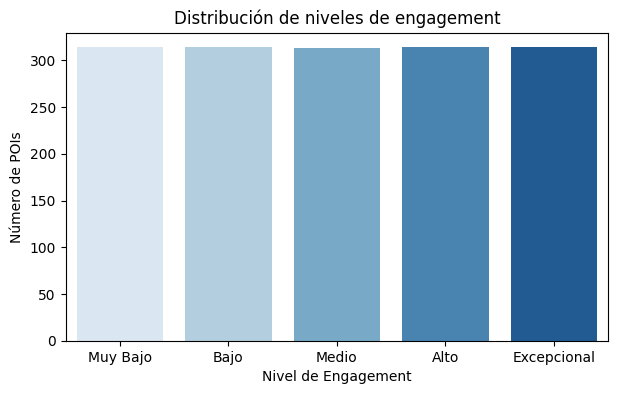

In [30]:
# Visualización del balance de clases
plt.figure(figsize=(7,4))
sns.countplot(x='engagement_level', data=df, order=labels, palette='Blues')
plt.title('Distribución de niveles de engagement')
plt.xlabel('Nivel de Engagement')
plt.ylabel('Número de POIs')
plt.show()

In [31]:
# Distribución numérica
print("\nDistribución y proporción de clases (%):")
(df['engagement_level'].value_counts(normalize=True) * 100).round(2)


Distribución y proporción de clases (%):


engagement_level
Muy Bajo       20.01
Bajo           20.01
Alto           20.01
Excepcional    20.01
Medio          19.95
Name: proportion, dtype: float64

## 2.10 Análisis de correlaciones entre variables

- Matriz de correlación entre engagement_score.

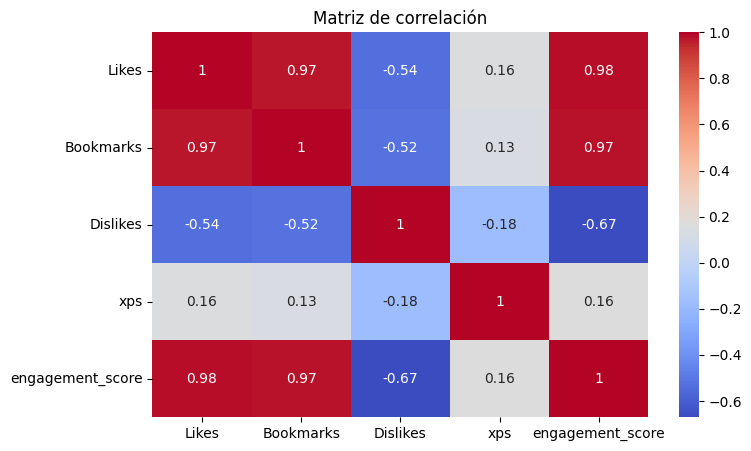

In [32]:
# Matriz Correlación
numeric_vars = ['Likes', 'Bookmarks', 'Dislikes', 'xps', 'engagement_score']
plt.figure(figsize=(8, 5))
sns.heatmap(df[numeric_vars].corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()

## 2.11 Análisis de la calidad de las imágenes

- Cálculo del score de calidad usando contraste y nitidez.
- Distribución del score de calidad de imagen.


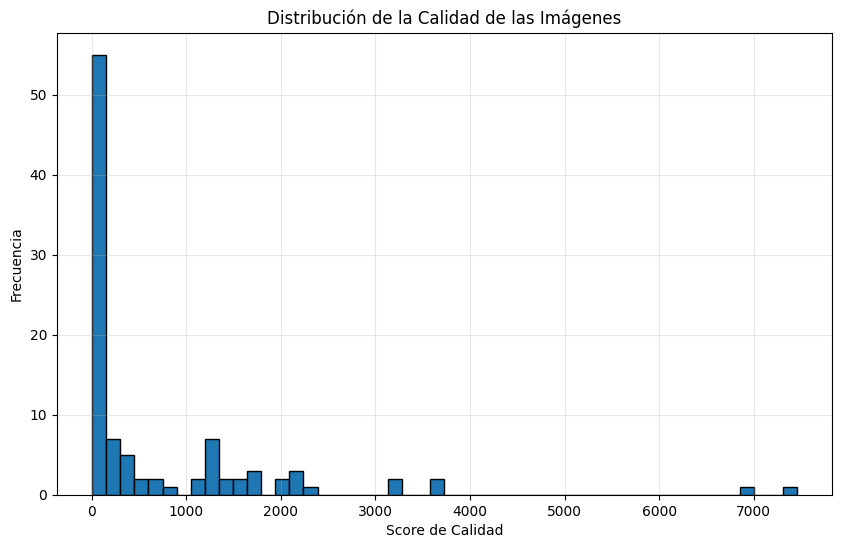

Calidad media: 724.53
Calidad mediana: 126.15


In [33]:
# Analizamos la calidad de las imágenes calculando el contraste y nitidez
image_quality_metrics = []

for _, row in df.sample(n=100, random_state=42).iterrows():
    # Leemos la imagen (RUTA CORREGIDA para tu estructura)
    img = cv2.imread(os.path.join(BASE_PATH, 'data', row['main_image_path']))

    # Convertimos a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Calculamos el contraste (desviación estándar)
    contrast = np.std(gray)

    # Calculamos la nitidez usando el Laplaciano
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    sharpness = np.var(laplacian)

    # Combinamos las métricas en un score
    quality_score = (contrast + sharpness) / 2
    image_quality_metrics.append(quality_score)

# Creamos el histograma
plt.figure(figsize=(10, 6))
plt.hist(image_quality_metrics, bins=50, edgecolor='black')
plt.title('Distribución de la Calidad de las Imágenes')
plt.xlabel('Score de Calidad')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
plt.show()

# Mostramos algunas estadísticas
print(f"Calidad media: {np.mean(image_quality_metrics):.2f}")
print(f"Calidad mediana: {np.median(image_quality_metrics):.2f}")

## 2.12 Relación entre calidad de imagen y engagement

- Análisis sobre una muestra de 100 imágenes.

- Cálculo de métrica de calidad de imagen basada en contraste y nitidez.

- Cálculo de correlación

- Scatter plot calidad vs engagement


Correlación calidad de imagen - engagement score: 0.54


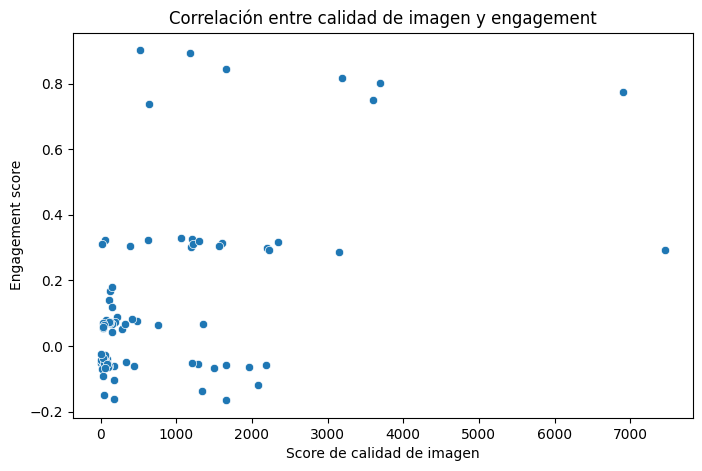

In [34]:
# Muestra  aleatoria de 100 imágenes
subset = df.sample(n=100, random_state=42)

# Cálculo métrica calidad (contraste + nitidez)
image_quality_metrics = []
for _, row in subset.iterrows():
    img = cv2.imread(os.path.join(BASE_PATH, 'data', row['main_image_path']))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    contrast = np.std(gray)
    sharpness = np.var(cv2.Laplacian(gray, cv2.CV_64F))
    quality_score = (contrast + sharpness) / 2
    image_quality_metrics.append(quality_score)

# Asignar los valores a las filas correspondientes
df.loc[subset.index, 'image_quality_score'] = image_quality_metrics

# Filtrar las filas con score de calidad calculado
df_plot = df.dropna(subset=['image_quality_score'])

# Cálculo de correlación
correl = df_plot[['image_quality_score', 'engagement_score']].corr().iloc[0, 1]
print(f"Correlación calidad de imagen - engagement score: {correl:.2f}")

# Scatter plot calidad vs engagement
plt.figure(figsize=(8, 5))
sns.scatterplot(x='image_quality_score', y='engagement_score', data=df_plot)
plt.title('Correlación entre calidad de imagen y engagement')
plt.xlabel('Score de calidad de imagen')
plt.ylabel('Engagement score')
plt.show()

# 3. Preprocesamiento de Datos

## 3.1 Normalización de variables numéricas

- Variables seleccionadas:
  - Likes
  - Dislikes
  - Bookmarks
  - xps
  - image_quality_score
  
- Normalización con MinMaxScaler para escalar valores entre 0 y 1



In [35]:
# Variables numéricas a normalizar
numeric_cols = ["Likes", "Dislikes", "Bookmarks", "xps", "image_quality_score", "tier"]

print(f"Variables a normalizar: {numeric_cols}")
print(f"Estadísticas antes de normalizar:")
print(df[numeric_cols].describe())

Variables a normalizar: ['Likes', 'Dislikes', 'Bookmarks', 'xps', 'image_quality_score', 'tier']
Estadísticas antes de normalizar:
              Likes      Dislikes    Bookmarks          xps  \
count   1569.000000   1569.000000  1569.000000  1569.000000   
mean    3623.908222   2526.305927   973.261950   750.382409   
std     4817.879374   2225.543360  1453.333948   228.319854   
min      100.000000     52.000000    50.000000     0.000000   
25%      464.000000    937.000000   116.000000   600.000000   
50%     1434.000000   2718.000000   306.000000   700.000000   
75%     6840.000000   3399.000000  1309.000000  1000.000000   
max    26425.000000  10999.000000  8157.000000  1000.000000   

       image_quality_score         tier  
count           100.000000  1569.000000  
mean            724.528419     1.541109  
std            1270.414374     0.637677  
min               5.804347     1.000000  
25%              42.335215     1.000000  
50%             126.152914     1.000000  
75%    

## 3.2 Codificación de variables categóricas

Se transforman las variables categóricas a un formato numérico para poder ser usadas en el modelo.

- tier: normalización.
- categories: one-hot encoding para los más frecuentes.
- tags: one-hot encoding para los más frecuentes.


In [37]:
# Parsear listas desde strings
df['categories_list'] = df['categories'].apply(ast.literal_eval)
df['tags_list'] = df['tags'].apply(ast.literal_eval)

# Top 10 categorías más frecuentes
all_categories = [cat for cat_list in df['categories_list'] for cat in cat_list]
category_counts = Counter(all_categories)
top_categories = [cat for cat, _ in category_counts.most_common(10)]
df['filtered_categories'] = df['categories_list'].apply(
    lambda lst: [c for c in lst if c in top_categories]
)

# One-hot encoding para categorías
mlb_cat = MultiLabelBinarizer()
categories_encoded = pd.DataFrame(
    mlb_cat.fit_transform(df['filtered_categories']),
    columns=[f"cat_{c}" for c in mlb_cat.classes_],
    index=df.index
)

# Top 15 tags más frecuentes
all_tags = [tag for tag_list in df['tags_list'] for tag in tag_list]
tag_counts = Counter(all_tags)
top_tags = [tag for tag, _ in tag_counts.most_common(15)]
df['filtered_tags'] = df['tags_list'].apply(
    lambda lst: [t for t in lst if t in top_tags]
)

# One-hot encoding para tags
mlb_tag = MultiLabelBinarizer()
tags_encoded = pd.DataFrame(
    mlb_tag.fit_transform(df['filtered_tags']),
    columns=[f"tag_{t}" for t in mlb_tag.classes_],
    index=df.index
)

## 3.3 Codificación de la variable target
- Verificación de distribución de clases de engagement_level
- LabelEncoder para convertir clases a índices consecutivos desde 0
- Necesario para compatibilidad con PyTorch CrossEntropyLoss

In [38]:
# Verificar distribución original
print("Distribución de engagement_level:")
print(df['engagement_level'].value_counts().sort_index())

# Codificar variable target para PyTorch
le_target = LabelEncoder()
df['engagement_level_encoded'] = le_target.fit_transform(df['engagement_level'])

print("\nMapeo de clases:")
for i, class_name in enumerate(le_target.classes_):
    print(f"  {class_name} -> {i}")

num_classes = len(le_target.classes_)

Distribución de engagement_level:
engagement_level
Muy Bajo       314
Bajo           314
Medio          313
Alto           314
Excepcional    314
Name: count, dtype: int64

Mapeo de clases:
  Alto -> 0
  Bajo -> 1
  Excepcional -> 2
  Medio -> 3
  Muy Bajo -> 4


## 3.3 División del dataset en conjuntos de entrenamiento, validación y test


- train: para entrenar el modelo (70%)
- val: para ajustar hiperparámetros y aplicar early stopping (15%)
- test: para evaluar el rendimiento final (15%)
- Uso de engagement_level_encoded para estratificación correcta

In [39]:
print("\n=== 3.4 DIVISIÓN DEL DATASET ===")

# División estratificada: train vs temp (val+test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df['engagement_level_encoded'],
    random_state=42
)

# División val y test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df['engagement_level_encoded'],
    random_state=42
)

print(f"Train: {len(train_df)} muestras")
print(f"Validation: {len(val_df)} muestras")
print(f"Test: {len(test_df)} muestras")


=== 3.4 DIVISIÓN DEL DATASET ===
Train: 1098 muestras
Validation: 235 muestras
Test: 236 muestras


## 3.5 normalizacion
- Ajuste del escalador solo en conjunto de entrenamiento
- Aplicación de transformación a train, val y test
- Previene filtración de información de validación/test

In [40]:
# Escalador ajustado solo en train
scaler_numeric = MinMaxScaler()
scaler_numeric.fit(train_df[numeric_cols])

# Aplicar transformación a todos los conjuntos
train_df_scaled = train_df.copy()
val_df_scaled = val_df.copy()
test_df_scaled = test_df.copy()

train_df_scaled[[col + "_norm" for col in numeric_cols]] = scaler_numeric.transform(train_df[numeric_cols])
val_df_scaled[[col + "_norm" for col in numeric_cols]] = scaler_numeric.transform(val_df[numeric_cols])
test_df_scaled[[col + "_norm" for col in numeric_cols]] = scaler_numeric.transform(test_df[numeric_cols])

## 3.6 Aplicación de codificaciones y preparación final
- Aplicación de encodings de categorías y tags a todos los conjuntos
- Concatenación de todas las features codificadas
- Preparación de datos en formato tensor para PyTorch

In [41]:
def apply_encodings(df_subset):
    df_encoded = df_subset.copy()

    # Categorías
    cat_encoded_subset = pd.DataFrame(
        mlb_cat.transform(df_subset['filtered_categories']),
        columns=[f"cat_{c}" for c in mlb_cat.classes_],
        index=df_subset.index
    )

    # Tags
    tag_encoded_subset = pd.DataFrame(
        mlb_tag.transform(df_subset['filtered_tags']),
        columns=[f"tag_{t}" for t in mlb_tag.classes_],
        index=df_subset.index
    )

    return pd.concat([df_encoded, cat_encoded_subset, tag_encoded_subset], axis=1)

# Aplicar a todos los conjuntos
train_df_final = apply_encodings(train_df_scaled)
val_df_final = apply_encodings(val_df_scaled)
test_df_final = apply_encodings(test_df_scaled)

# Selección de features para el modelo
numeric_features = [col + "_norm" for col in numeric_cols]
category_features = [col for col in train_df_final.columns if col.startswith('cat_')]
tag_features = [col for col in train_df_final.columns if col.startswith('tag_')]
model_features = numeric_features + category_features + tag_features

print(f"Total features para el modelo: {len(model_features)}")

Total features para el modelo: 31


## 3.7 Conversión a tensores PyTorch
- Conversión de features y targets a tensores float32 e int64
- Preparación final de datos para entrenamiento del modelo
- Verificación de dimensiones y rangos

In [42]:
def prepare_data_for_pytorch(df_subset, features, target_col='engagement_level_encoded'):
    X = df_subset[features].values.astype(np.float32)
    y = df_subset[target_col].values.astype(np.int64)
    return torch.tensor(X), torch.tensor(y)

# Preparar datos para PyTorch
X_train, y_train = prepare_data_for_pytorch(train_df_final, model_features)
X_val, y_val = prepare_data_for_pytorch(val_df_final, model_features)
X_test, y_test = prepare_data_for_pytorch(test_df_final, model_features)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Guardar objetos importantes
preprocessing_objects = {
    'scaler_numeric': scaler_numeric,
    'mlb_cat': mlb_cat,
    'mlb_tag': mlb_tag,
    'le_target': le_target,
    'model_features': model_features,
    'num_classes': num_classes
}

X_train shape: torch.Size([1098, 31])
y_train shape: torch.Size([1098])


# 4. Definición y Entrenamiento del Modelo

## 4.1 Configuración del dispositivo y parámetros
- Configuración de GPU/CPU para entrenamiento
- Definición de hiperparámetros del modelo
- Configuración de paths para imágenes

In [46]:
# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

# Hiperparámetros
BATCH_SIZE = 10
LEARNING_RATE = 0.0001
NUM_EPOCHS = 10
IMG_SIZE = 224
PATIENCE = 3

# Path base de las imágenes
BASE_IMAGE_PATH = "data/"

# Limpiar datos de NaN/Inf
X_train = torch.nan_to_num(X_train, nan=0.0, posinf=1.0, neginf=-1.0)
X_val = torch.nan_to_num(X_val, nan=0.0, posinf=1.0, neginf=-1.0)
X_test = torch.nan_to_num(X_test, nan=0.0, posinf=1.0, neginf=-1.0)

Usando dispositivo: cuda


## 4.2 Dataset personalizado para datos multimodales
- Clase Dataset que combina imágenes y metadatos
- Transformaciones de imágenes para entrenamiento y validación
- Carga y preprocesamiento de datos en tiempo real

In [47]:
class POIDataset(Dataset):
    def __init__(self, X_metadata, y_labels, image_paths, transform=None):
        self.X_metadata = X_metadata
        self.y_labels = y_labels
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.X_metadata)

    def __getitem__(self, idx):
        # Metadatos
        metadata = self.X_metadata[idx]
        label = self.y_labels[idx]

        # Cargar imagen
        img_path = os.path.join(BASE_IMAGE_PATH, self.image_paths[idx])
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except:
            # Imagen por defecto si hay error
            image = torch.zeros(3, IMG_SIZE, IMG_SIZE)

        return {
            'image': image,
            'metadata': torch.tensor(metadata, dtype=torch.float32),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Transformaciones para las imágenes
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

## 4.3 Preparación de paths de imágenes
- Extracción de rutas de imágenes desde el dataframe
- Creación de datasets para train, validation y test
- Configuración de DataLoaders con batch size

In [48]:
# Obtener paths de imágenes de los DataFrames
train_img_paths = train_df_final['main_image_path'].values
val_img_paths = val_df_final['main_image_path'].values
test_img_paths = test_df_final['main_image_path'].values

# Verificar que tenemos las columnas correctas
print("Columnas disponibles en el dataset:")
print([col for col in train_df_final.columns if 'image' in col.lower() or 'path' in col.lower()])

# Verificar valores nulos en paths de imágenes
print(f"\nValores nulos en main_image_path:")
print(f"Train: {train_df_final['main_image_path'].isnull().sum()}")
print(f"Val: {val_df_final['main_image_path'].isnull().sum()}")
print(f"Test: {test_df_final['main_image_path'].isnull().sum()}")

# Ejemplos de paths
print(f"\nEjemplos de paths de imágenes:")
print(train_img_paths[:3])

# Crear datasets
train_dataset = POIDataset(X_train.numpy(), y_train.numpy(), train_img_paths, transform_train)
val_dataset = POIDataset(X_val.numpy(), y_val.numpy(), val_img_paths, transform_val)
test_dataset = POIDataset(X_test.numpy(), y_test.numpy(), test_img_paths, transform_val)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Recrear con batch size optimizado
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"DataLoaders optimizados - batch_size: {BATCH_SIZE}")

Columnas disponibles en el dataset:
['main_image_path', 'image_quality_score', 'image_quality_score_norm']

Valores nulos en main_image_path:
Train: 0
Val: 0
Test: 0

Ejemplos de paths de imágenes:
['data_main/a5fe0614-80f3-434d-ba1b-7561f9db4284/main.jpg'
 'data_main/2053e868-01b9-457d-833f-9b21d17fd15d/main.jpg'
 'data_main/04c4b257-4285-411a-a07a-9987378d993e/main.jpg']
Train batches: 110
Val batches: 24
Test batches: 24
DataLoaders optimizados - batch_size: 10


## 4.4 Definición del modelo multimodal
- CNN preentrenada (ResNet18) para extracción de características de imágenes
- MLP para procesamiento de metadatos
- Fusión de características y clasificador final

In [49]:
class MultimodalPOIModel(nn.Module):
    def __init__(self, metadata_size, num_classes, dropout_rate=0.2):
        super(MultimodalPOIModel, self).__init__()

        # CNN para imágenes (ResNet18 preentrenado)
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Identity()
        cnn_features = 512

        # Congelar capas iniciales de la CNN
        for param in list(self.cnn.parameters())[:-10]:
            param.requires_grad = False

        # MLP para metadatos con BatchNorm para estabilidad
        self.metadata_mlp = nn.Sequential(
            nn.Linear(metadata_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Clasificador final (fusión) con BatchNorm
        combined_features = cnn_features + 128
        self.classifier = nn.Sequential(
            nn.Linear(combined_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes)
        )

        # Inicialización de pesos mejorada
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, image, metadata):
        # Características de imagen
        img_features = self.cnn(image)

        # Características de metadatos
        meta_features = self.metadata_mlp(metadata)

        # Fusionar características
        combined = torch.cat([img_features, meta_features], dim=1)

        # Clasificación final
        output = self.classifier(combined)
        return output

# Crear modelo
metadata_size = X_train.shape[1]
model = MultimodalPOIModel(metadata_size, num_classes).to(device)

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parámetros totales: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")

Parámetros totales: 11,399,877
Parámetros entrenables: 5,076,613


## 4.5 Configuración de entrenamiento
- Función de pérdida CrossEntropyLoss para clasificación multiclase
- Optimizador Adam con weight decay
- Scheduler para reducir learning rate progresivamente

In [50]:
# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4, eps=1e-8)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, min_lr=1e-7)

## 4.6 Funciones de entrenamiento y validación
- Función de entrenamiento por época con backpropagation
- Función de validación para evaluar rendimiento
- Cálculo de métricas de accuracy y loss

In [51]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, batch in enumerate(dataloader):
        try:
            images = batch['image'].to(device)
            metadata = batch['metadata'].to(device)
            labels = batch['label'].to(device)

            # Verificar NaN en inputs
            if torch.isnan(images).any() or torch.isnan(metadata).any():
                continue

            optimizer.zero_grad()
            outputs = model(images, metadata)

            # Verificar NaN en outputs
            if torch.isnan(outputs).any() or torch.isinf(outputs).any():
                continue

            loss = criterion(outputs, labels)

            # Verificar NaN en loss
            if torch.isnan(loss) or torch.isinf(loss):
                continue

            loss.backward()

            # Gradient clipping para evitar explosión de gradientes
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        except Exception as e:
            print(f"Error en batch {batch_idx}: {e}")
            continue

    epoch_loss = running_loss / len(dataloader) if len(dataloader) > 0 else float('inf')
    epoch_acc = 100 * correct / total if total > 0 else 0
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            try:
                images = batch['image'].to(device)
                metadata = batch['metadata'].to(device)
                labels = batch['label'].to(device)

                outputs = model(images, metadata)
                loss = criterion(outputs, labels)

                # Solo contar si el loss es válido
                if not (torch.isnan(loss) or torch.isinf(loss)):
                    running_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            except Exception as e:
                continue

    epoch_loss = running_loss / len(dataloader) if len(dataloader) > 0 else float('inf')
    epoch_acc = 100 * correct / total if total > 0 else 0
    return epoch_loss, epoch_acc

## 4.7 Loop de entrenamiento con early stopping
- Entrenamiento por épocas con seguimiento de métricas
- Early stopping para evitar overfitting
- Guardado del mejor modelo basado en validation loss

In [53]:
NUM_EPOCHS = 10
PATIENCE = 3

train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

print("Iniciando entrenamiento optimizado...")

EVAL_EVERY = 2

for epoch in range(NUM_EPOCHS):
    print(f"\nÉpoca {epoch+1}/{NUM_EPOCHS}")

    # Entrenamiento
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

    # Validación
    if epoch % EVAL_EVERY == 0 or epoch == NUM_EPOCHS - 1:
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"  Nuevo mejor modelo guardado")
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping en época {epoch+1}")
            break

        # Scheduler solo cuando hay validación
        scheduler.step(val_loss)

    else:

        if val_losses:
            val_losses.append(val_losses[-1])
            val_accs.append(val_accs[-1])
        print(f"  (Validación saltada)")

# Cargar mejor modelo
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nMejor modelo cargado con Val Loss: {best_val_loss:.4f}")
else:
    print("\nNo se encontró mejor modelo")

print("Entrenamiento completado!")

Iniciando entrenamiento optimizado...

Época 1/10
  Train Loss: 1.6808, Train Acc: 28.23%
  Val Loss: 1.3526, Val Acc: 41.28%
  Nuevo mejor modelo guardado

Época 2/10
  Train Loss: 1.5110, Train Acc: 36.25%
  (Validación saltada)

Época 3/10
  Train Loss: 1.4355, Train Acc: 40.44%
  Val Loss: 1.1976, Val Acc: 52.77%
  Nuevo mejor modelo guardado

Época 4/10
  Train Loss: 1.4151, Train Acc: 41.44%
  (Validación saltada)

Época 5/10
  Train Loss: 1.3459, Train Acc: 42.53%
  Val Loss: 1.1537, Val Acc: 54.89%
  Nuevo mejor modelo guardado

Época 6/10
  Train Loss: 1.2899, Train Acc: 47.81%
  (Validación saltada)

Época 7/10
  Train Loss: 1.2713, Train Acc: 48.00%
  Val Loss: 1.1156, Val Acc: 57.02%
  Nuevo mejor modelo guardado

Época 8/10
  Train Loss: 1.2604, Train Acc: 49.00%
  (Validación saltada)

Época 9/10
  Train Loss: 1.2771, Train Acc: 48.54%
  Val Loss: 1.0823, Val Acc: 61.70%
  Nuevo mejor modelo guardado

Época 10/10
  Train Loss: 1.2678, Train Acc: 50.09%
  Val Loss: 1.0594,

## 4.8 Visualización del entrenamiento
- Gráficos de evolución de loss y accuracy
- Análisis de la convergencia del modelo
- Identificación de posible overfittin-

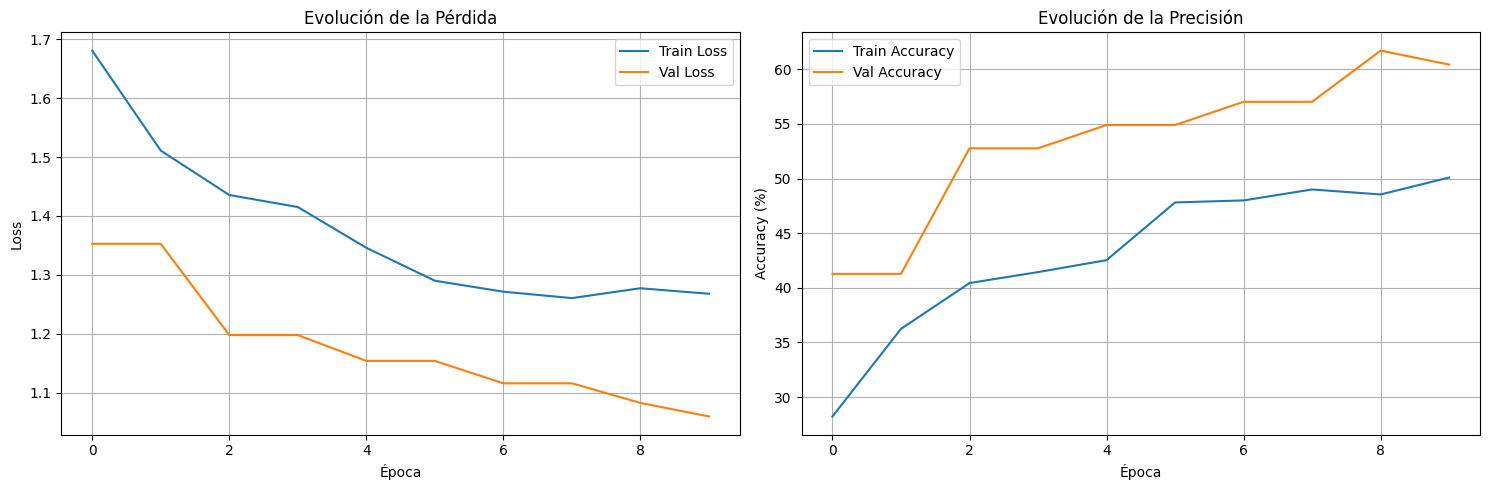

In [54]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Evolución de la Pérdida')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Evolución de la Precisión')
plt.xlabel('Época')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 4.9 Evaluación final en conjunto de test
- Predicciones en conjunto de test no visto durante entrenamiento
- Cálculo de métricas finales: accuracy, precision, recall, F1-score
- Matriz de confusión para análisis detallado


RESULTADOS FINALES:
Test Accuracy: 0.6356

Reporte de clasificación:
              precision    recall  f1-score   support

        Alto       0.56      0.49      0.52        47
        Bajo       0.62      0.11      0.18        47
 Excepcional       0.88      0.96      0.92        48
       Medio       0.51      0.72      0.60        47
    Muy Bajo       0.62      0.89      0.73        47

    accuracy                           0.64       236
   macro avg       0.64      0.63      0.59       236
weighted avg       0.64      0.64      0.59       236



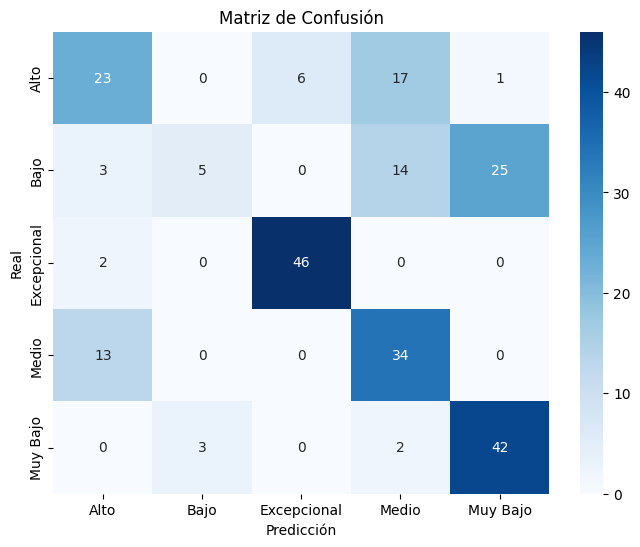

In [55]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            metadata = batch['metadata'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, metadata)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels

# Evaluación en test
test_predictions, test_labels = evaluate_model(model, test_loader, device)

# Métricas finales
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"\nRESULTADOS FINALES:")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Reporte de clasificación
class_names = le_target.classes_
print("\nReporte de clasificación:")
print(classification_report(test_labels, test_predictions, target_names=class_names))

# Matriz de confusión
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

## 4.10 Guardado del modelo entrenado
- Guardado del modelo y sus parámetros
- Guardado de objetos de preprocesamiento necesarios para inferencia
- Preparación para deployment o uso posterior

In [56]:
# Guardar modelo
torch.save({
    'model_state_dict': model.state_dict(),
    'model_params': {
        'metadata_size': metadata_size,
        'num_classes': num_classes
    },
    'preprocessing_objects': preprocessing_objects,
    'class_names': class_names,
    'test_accuracy': test_accuracy
}, 'poi_engagement_model.pth')

print("Modelo guardado como 'poi_engagement_model.pth'")

Modelo guardado como 'poi_engagement_model.pth'
